In [158]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn
%matplotlib inline
import pandas as pd
import scipy

In [113]:
import sklearn.metrics
import mir_eval

In [114]:
import cPickle as pickle

In [115]:
np.set_printoptions(precision=3)
seaborn.set(style='darkgrid')

AttributeError: 'function' object has no attribute 'outer'

In [162]:
np.add.outer

<function outer>

In [186]:
def plot_curve(file='', intervals=None, labels=None, scores=None, norm=None):
    
    label_agreement = np.zeros((len(labels), len(labels)), dtype=bool)
    
    for i in range(len(labels)):
        for j in range(i, len(labels)):
            label_agreement[i, j] = (labels[i] == labels[j])
            label_agreement[j, i] = label_agreement[i, j]
    
    time_norm = 1
    
    durations = np.diff(intervals, axis=1).ravel()
    
    if norm == 'min':
        time_norm = np.minimum.outer(durations, durations)
        
    elif norm == 'max':
        time_norm = np.maximum.outer(durations, durations)
        
    elif norm == 'hmean':
        time_norm = 2./np.add.outer(durations, durations)
        time_norm *= np.multiply.outer(durations, durations)
    
    # TODO: have the label agreement index out nan-valued scores
    
    scores = scores / time_norm
    
    label_agreement[np.tril_indices_from(label_agreement, k=0)] = False
    
    label_agreement[~np.isfinite(scores)] = False
    
    label_disagreement = ~label_agreement
    
    label_disagreement[np.tril_indices_from(label_disagreement, k=0)] = False
    
    label_disagreement[~np.isfinite(scores)] = False
    
    tp_scores = scores[label_agreement]
    fp_scores = scores[label_disagreement]
    
    num_pos = np.sum(label_agreement)
    num_neg = np.sum(label_disagreement)
    
    y_true = np.concatenate([np.zeros(len(tp_scores)), np.ones(len(fp_scores))])
    y_score = np.concatenate([tp_scores, fp_scores])
    
    fpr, tpr, thr = sklearn.metrics.roc_curve(y_true, y_score)
    
    tp = num_pos * tpr
    fp = num_neg * fpr
    
    precision = tp / (tp + fp)
    recall = tpr
    
    fmeasure = np.asarray([mir_eval.util.f_measure(p, r) for p, r in zip(precision, recall)])
    
    k = np.argmax(fmeasure)
    thr_opt = thr[k]
    
    plt.figure(figsize=(12, 4))
    plt.subplot(1,3,1)
    plt.plot([0, 1], [0, 1], linestyle='--', alpha=0.5)
    
    plt.plot(fpr, tpr)
    plt.plot(fpr[k], tpr[k], color='r', marker='*', markersize=10, alpha=0.5)
    
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.title(file)
    
    plt.subplot(1,3,2)
    plt.plot(precision, recall)
    plt.xlabel('Precision')
    plt.ylabel('Recall')
    plt.title('norm={}'.format(norm))
    
    plt.subplot(1,3,3)
    plt.plot(thr, fmeasure)
    k = np.argmax(fmeasure)
    plt.plot(thr[k], fmeasure[k], marker='*', markersize=10, alpha=0.5, color='r')
    
    plt.xlabel(r'$\theta$')
    plt.ylabel('$F_1$')
    plt.title(r'({:.3f}, {:.3f})'.format(thr[k], fmeasure[k]))
    plt.tight_layout()
    
    return thr[k]

In [154]:
vars().update(pickle.load(open('../data/scores_datasetESALAMI_levelElarge_scale_distEL2.pk', 'r')))

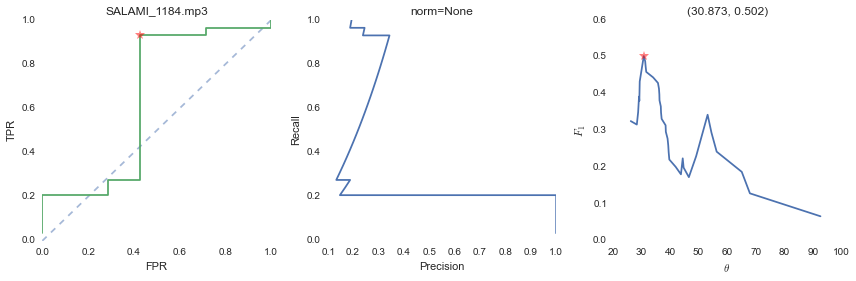

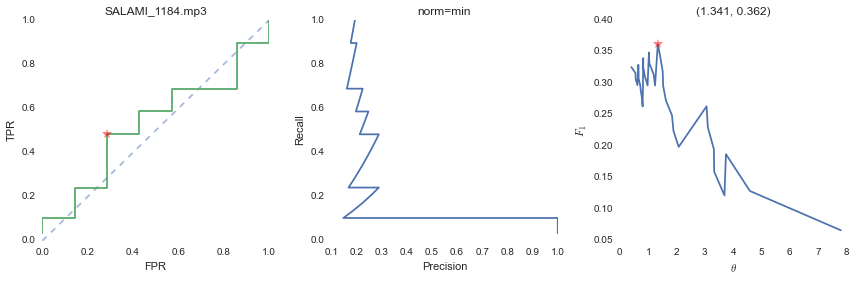

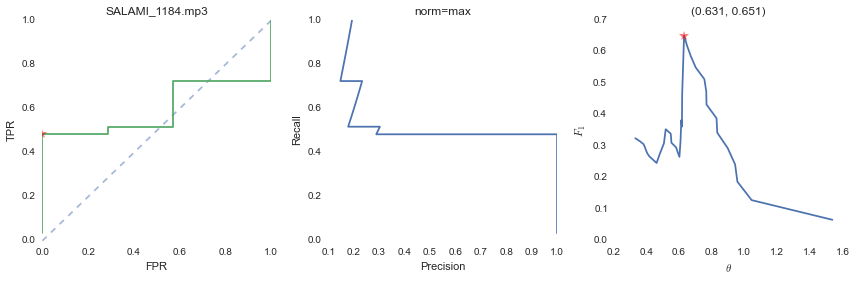

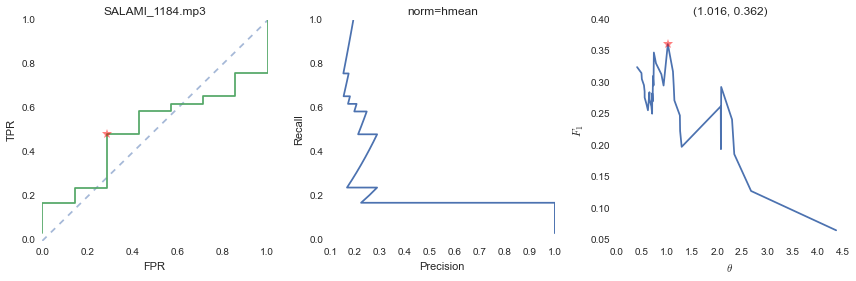

In [189]:
k = 425
for norm in [None, 'min', 'max', 'hmean']:
    
    plot_curve(norm=norm, **file_scores[k])